In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('nlp_cleaned_reviews.csv')

In [5]:
df['sentiment'] = df['rating'].map({1.0: 'Negative', 2.0: 'Negative', 3.0: 'Neutral', 4.0: 'Positive', 5.0: 'Positive'})

In [7]:
df = df.drop('Unnamed: 0', axis=1)

In [11]:
holdout_df = df[df['sentiment'] == 'Neutral']

In [42]:
test_df = df[df['sentiment'] != 'Neutral']
test_df.loc[:,'str_desc'] = test_df.loc[:,'str_desc'].fillna('null')
test_df['str_desc'].isnull().any()

/Users/ryankirkland/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


False

In [51]:
X = test_df['str_desc']
y = test_df['rating']

In [52]:
tfidf = TfidfVectorizer()
vectorized = tfidf.fit_transform(X)

In [53]:
vectorized.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
print(vectorized)

  (0, 2488)	0.04638674906393227
  (0, 1481)	0.05914728905781805
  (0, 7896)	0.09983443113231168
  (0, 3834)	0.11118320436734135
  (0, 1890)	0.07432892705142874
  (0, 4187)	0.07083673927727326
  (0, 3033)	0.10732996838425193
  (0, 7214)	0.08962626818467803
  (0, 1479)	0.04521957846753405
  (0, 889)	0.08225890490159021
  (0, 5865)	0.05576079289591428
  (0, 6229)	0.060497475013483966
  (0, 3794)	0.08876183422873749
  (0, 3054)	0.0964683061949163
  (0, 5558)	0.042525884333342014
  (0, 3048)	0.10732996838425193
  (0, 4189)	0.08511953295988664
  (0, 4996)	0.07432892705142874
  (0, 7809)	0.11661403546200917
  (0, 6739)	0.07827749494964838
  (0, 2036)	0.11118320436734135
  (0, 2775)	0.06101468512247885
  (0, 6284)	0.06356259677722333
  (0, 946)	0.08278423017443975
  (0, 3082)	0.058432768856211535
  :	:
  (4441, 7275)	0.30379261275303326
  (4441, 4113)	0.28509769731581996
  (4441, 4817)	0.23257726255817063
  (4441, 1338)	0.25305777360938375
  (4441, 1578)	0.5455673426391456
  (4441, 2074)	0.165

In [95]:
dtrain = xgb.DMatrix(vectorized, label=y)
param = {'max_depth':2, 'eta':1, 'objective':'multi:softmax'}
num_round = 10

In [107]:
print('running cross validation, with customized loss function')
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1.0 - preds)
    return grad, hess
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'error', float(sum(labels != (preds > 0.0))) / len(labels)

param = {'max_depth':2, 'eta':1}
# train with customized objective
xgb.cv(param, dtrain, num_round, nfold=5, seed=0,
       obj=logregobj, feval=evalerror)

running cross validation, with customized loss function


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-error-mean,train-error-std,test-error-mean,test-error-std
0,11.422997,0.027566,11.429634,0.091457,0.84856,0.003028,0.848563,0.012112
1,10532.280664,302.530968,10532.285938,302.526947,0.84856,0.003028,0.848563,0.012112
2,21619.481641,331.803524,21619.483594,331.800637,0.84856,0.003028,0.848563,0.012112
3,32706.687891,361.796223,32706.684375,361.792322,0.84856,0.003028,0.848563,0.012112
4,43793.874219,392.329649,43793.884375,392.336428,0.84856,0.003028,0.848563,0.012112
5,54881.078906,423.311527,54881.081250,423.315144,0.84856,0.003028,0.848563,0.012112
6,65968.267187,454.614474,65968.290625,454.641139,0.84856,0.003028,0.848563,0.012112
7,77055.450000,486.217791,77055.489062,486.242672,0.84856,0.003028,0.848563,0.012112
8,88142.693750,518.087922,88142.681250,518.071384,0.84856,0.003028,0.848563,0.012112
9,99229.912500,550.065062,99229.876563,550.097905,0.84856,0.003028,0.848563,0.012112


In [108]:
xgb.cv(param, dtrain, num_round)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.400561,0.002416,1.413125,0.004165
1,1.349563,0.000726,1.395075,0.002494
2,1.308287,0.003116,1.365838,0.006108
3,1.271790,0.001926,1.338711,0.011132
4,1.244128,0.000500,1.315528,0.006490
5,1.218859,0.000909,1.299603,0.011441
6,1.197934,0.001792,1.291522,0.014722
7,1.178262,0.002372,1.281816,0.021300
8,1.160784,0.004115,1.277687,0.019407
9,1.145388,0.004810,1.272535,0.011766


In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [109]:
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, X, y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean(), scores)

Accuracy for Tf-Idf & XGBoost Classifier :  0.7662048156142645 [0.75028121 0.76602925 0.77052868 0.76377953 0.78040541]


In [91]:
pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, X, y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

Accuracy for Tf-Idf & RandomForest :  0.7574276188449417


In [142]:
y_labeled = test_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(vectorized, y_labeled)

In [143]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [144]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [145]:
y_pred_proba = rf.predict_proba(X_test)
y_pred = rf.predict(X_test)

In [151]:
y_pred_proba
y_pred

array(['Positive', 'Positive', 'Positive', ..., 'Positive', 'Positive',
       'Positive'], dtype=object)

In [159]:
rf.score(X_test, y_test)

0.8640864086408641

In [148]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [149]:
confusion_matrix(y_test, y_pred, labels=['Positive', 'Negative'])

array([[862,   7],
       [144,  98]])

In [154]:
feature_importances = np.argsort(rf.feature_importances_)

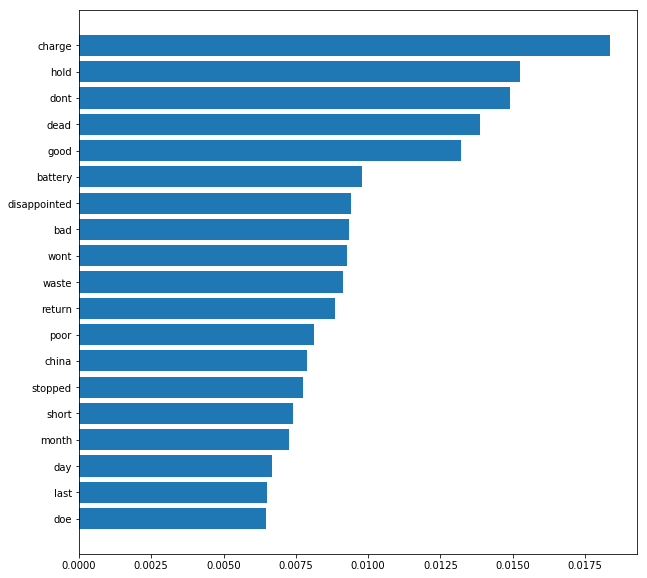

In [187]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(vect_df.columns[feature_importances][-20:-1], rf.feature_importances_[feature_importances][-20:-1]);

In [162]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)

MultinomialNB()

In [163]:
clf_nb.predict(X_test)

array(['Positive', 'Positive', 'Positive', ..., 'Positive', 'Positive',
       'Positive'], dtype='<U8')

In [164]:
clf_nb.score(X_test, y_test)

0.7893789378937894

In [167]:
len(tfidf.get_feature_names())

7918

In [172]:
vect_df = pd.DataFrame(vectorized.toarray(), columns=tfidf.get_feature_names())

In [173]:
vect_df

,00,010,011,02,02mm,036a,0399,03v,0403,0405,...,zapper,zero,zeropower,zillion,zinc,zombie,zoom,zwave,éste,útiles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['sluggish', 'fiddled', 'field', 'fierce', 'fifteen', 'rifle',
       'rewriting', 'rewrite', 'filled', 'fillin',
       ...
       'wont', 'bad', 'disappointed', 'battery', 'good', 'dead', 'dont',
       'hold', 'charge', 'great'],
      dtype='object', length=7918)